In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

import utils

### Get grid and case info

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)

In [5]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1/'

In [6]:
variables = ['photoC_TOT_zint_100m',
             'diatChl','spChl','coccoChl','diazChl','TEMP']

In [7]:
ds_fosi = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time','KMT'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    
    
    ### take care of the 3D vars

    if var=='diatChl': ### just get surface chl
        ds_tmp[var]= ds_tmp[var].isel(z_t_150m=0)
    
    if var=='spChl': ### just get surface chl
        ds_tmp[var]= ds_tmp[var].isel(z_t_150m=0)
        
    if var=='diazChl': ### just get surface chl
        ds_tmp[var]= ds_tmp[var].isel(z_t_150m=0)
    
    if var=='coccoChl': ### just get surface chl
        ds_tmp[var]= ds_tmp[var].isel(z_t_150m=0)
        
    if var=='diatC':
        ds_tmp[var]= (ds_tmp[var].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
        
    if var=='spC':
        ds_tmp[var]= (ds_tmp[var].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
        
    if var=='diazC':
        ds_tmp[var]= (ds_tmp[var].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
        
    if var=='coccoC':
        ds_tmp[var]= (ds_tmp[var].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
        
    if var=='mesozooC':
        ds_tmp[var]= (ds_tmp[var].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
        
    if var=='microzooC':
        ds_tmp[var]= (ds_tmp[var].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')    
        
    if var=='TEMP':
        ds_tmp[var]= ds_tmp[var].isel(z_t=0) # just grab the top level for temp
        
    ds_fosi = xr.merge([ds_fosi,ds_tmp])

starting on  photoC_TOT_zint_100m
starting on  diatChl
starting on  spChl
starting on  coccoChl
starting on  diazChl
starting on  TEMP


### Calculate some variables

In [8]:
ds_fosi['Chl']=(ds_fosi['diatChl'] + ds_fosi['spChl'] + ds_fosi['coccoChl'] + ds_fosi['diazChl'])

In [9]:
ds_fosi.Chl

<xarray.DataArray 'Chl' (time: 768, nlat: 384, nlon: 320)>
dask.array<add, shape=(768, 384, 320), dtype=float32, chunksize=(768, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time     (time) object 1958-02-01 00:00:00 ... 2022-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

### Make annual means

In [10]:
%%time

ds_fosi["time"] = ds_fosi.time_bound.compute().mean(dim="d2")

ds_ann = ds_fosi.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 2min 7s, sys: 5.17 s, total: 2min 12s
Wall time: 2min 26s


### DJF and JJA means

In [11]:
ds_jja = xr.Dataset()
ds_djf = xr.Dataset()

i = 5 # june index for 'jja' averages
s = 11 #december index for 'djf' averages, summer (s)

for year in np.arange(0,64,1): #omip simulation is 1958 to 2021, 641 years long
        
 
        
        ### JJA
        jja = ds_fosi.isel(time=slice(i,i+3)).mean(dim='time')

        ds_jja = xr.concat([ds_jja,jja],dim='time')

        i = i + 12
        
                        
        ### DJF
        djf = ds_fosi.isel(time=slice(s,s+3)).mean(dim='time')

        ds_djf = xr.concat([ds_djf,djf],dim='time')

        s = s + 12
        

In [12]:
SST_chl_corr = xr.corr(ds_ann.Chl, ds_ann.TEMP, dim='time')

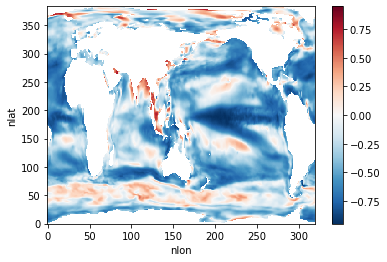

In [13]:
SST_chl_corr.plot()

In [14]:
SST_NPP_corr = xr.corr(ds_ann.photoC_TOT_zint_100m, ds_ann.TEMP, dim='time')

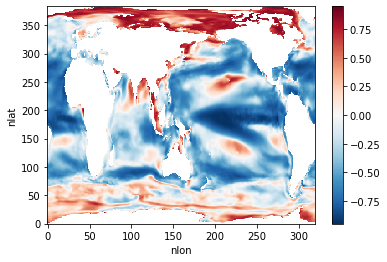

In [15]:
SST_NPP_corr.plot()

In [16]:
djf_SST_Chl_corr = xr.corr(ds_djf.Chl, ds_djf.TEMP, dim='time')

In [17]:
djf_SST_NPP_corr = xr.corr(ds_djf.photoC_TOT_zint_100m, ds_djf.TEMP, dim='time')

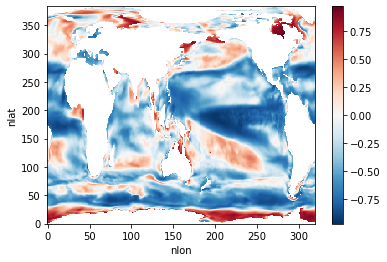

In [18]:
djf_SST_NPP_corr.plot()

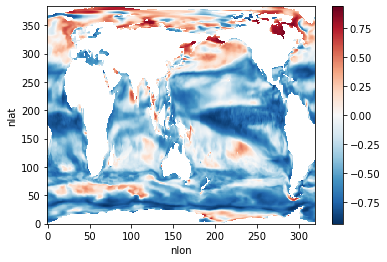

In [19]:
djf_SST_Chl_corr.plot()

### let's get a chlorophyll  from MODIS

In [20]:
files = sorted(glob(f'/glade/work/kristenk/satellite_data/Chl_annual/A??????????????.L3m_YR_CHL_chlor_a_9km.nc'))       
ds_sat_chl = xr.open_mfdataset(files, concat_dim="time", combine='nested').compute()

In [21]:
ds_sat_chl

<xarray.Dataset>
Dimensions:  (eightbitcolor: 256, lat: 3418, lon: 6811, rgb: 3, time: 18)
Coordinates:
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.79 ... 89.79 89.88 89.96
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.8 ... 179.9 180.0 180.0
Dimensions without coordinates: eightbitcolor, rgb, time
Data variables:
    chlor_a  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    palette  (time, rgb, eightbitcolor) uint8 147 0 108 144 0 111 ... 0 0 0 0 0
Attributes: (12/64)
    product_name:                      A20030012003365.L3m_YR_CHL_chlor_a_9km.nc
    instrument:                        MODIS
    title:                             HMODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    temporal_range:                    year
    ...                                ...
    identifier_product_doi:            10.5067/AQUA/MODIS/L3M/CHL/2018
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         5451655
    data_minimum:                      0.008466447
    data_maximum:                      98.55025

In [22]:
tlen = 18
ny = 2160
nx = 4320

files = sorted(glob('/glade/work/kristenk/satellite_data/Chl_annual/A??????????????.L3m_YR_CHL_chlor_a_9km.nc'))
tlen=len(files)

modis_chl = np.full((tlen,ny,nx),-9999.)

t = 0
for file in files:
    ds_tmp = xr.open_dataset(file)
    modis_chl[t,:,:] = np.flipud(ds_tmp.chlor_a.values)
    t = t + 1

modis_chl = xr.DataArray(modis_chl, dims=('time','lat','lon'))

ds_sat_chl = xr.Dataset()
ds_sat_chl['chl'] = modis_chl

In [23]:
lat_data = np.arange(-90+1/24,90,1/12)
lon_data = np.arange(-180+1/24,180,1/12)

In [24]:
ds_sat_chl['lat'] = lat_data

In [25]:
ds_sat_chl['lon'] = lon_data

In [26]:
ds_sat_chl['time'] = np.arange(2003,2021,1)

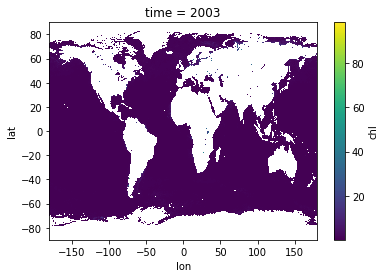

In [27]:
ds_sat_chl.chl.isel(time=0).plot()

### let's get VGPM NPP

In [28]:
import pandas as pd

In [29]:
%%time
files = sorted(glob(f'/glade/work/kristenk/satellite_data/VGPM/netcdf/vgpm.???????.all.nc'))       
ds_vgpm = xr.open_mfdataset(files, concat_dim="time", combine='nested',).compute()

CPU times: user 6.92 s, sys: 4.83 s, total: 11.8 s
Wall time: 1min 16s


In [30]:
ds_vgpm = ds_vgpm.where(ds_vgpm > -9999.)

In [31]:
time = pd.date_range(start="2003-01-01", end="2022-01-01",freq="M")

In [32]:
ds_vgpm['time']= time

In [33]:
%%time
ds_vgpm_ann = ds_vgpm.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 4.9 s, sys: 1.41 s, total: 6.31 s
Wall time: 6.89 s


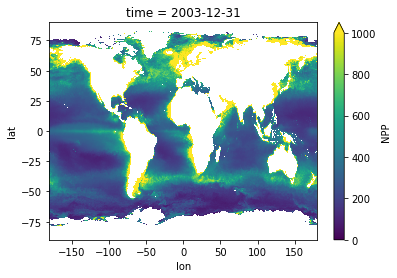

In [34]:
ds_vgpm_ann.NPP.isel(time=0).plot(vmin=0,vmax=1000)

In [35]:
ds_vgpm_ann['time'] = np.arange(2003,2022,1)

In [36]:
ds_vgpm_ann['lat'] = lat_data
ds_vgpm_ann['lon'] = lon_data

### let's get SST from MODIS

In [37]:
def preprocess(ds):
    ds['lat'] = sat_lats
    ds['lon'] = sat_lons
    return ds

In [38]:
# %%time
# files = sorted(glob(f'/glade/work/kristenk/satellite_data/SST_annual/AQUA_MODIS.????????_????????.L3m.YR.SST.sst.9km.nc'))       
# ds_sat_sst = xr.open_mfdataset(files, concat_dim="time", combine='nested', preprocess=preprocess ).compute()

In [39]:
#tlen = 20
ny = 2160
nx = 4320

files = sorted(glob('/glade/work/kristenk/satellite_data/SST_annual/AQUA_MODIS.????????_????????.L3m.YR.SST.sst.9km.nc'))
tlen=len(files)

modis_sst = np.full((tlen,ny,nx),-9999.)

t = 0
for file in files:
    ds_tmp = xr.open_dataset(file)
    modis_sst[t,:,:] = np.flipud(ds_tmp.sst.values)
    t = t + 1

modis_sst = xr.DataArray(modis_sst, dims=('time','lat','lon'))

ds_sat_sst = xr.Dataset()
ds_sat_sst['sst'] = modis_sst

In [40]:
ds_sat_sst['lat']= lat_data
ds_sat_sst['lon']= lon_data

In [41]:
ds_sat_sst = ds_sat_sst.isel(time=slice(0,18))

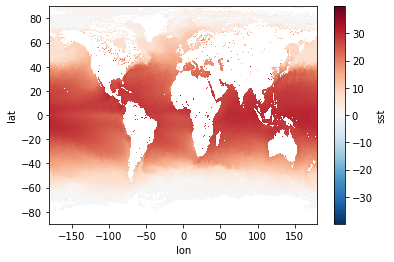

In [42]:
ds_sat_sst.sst.isel(time=0).plot()

In [43]:
ds_sat_sst['time'] = np.arange(2003,2021,1)

In [44]:
ds_sat_sst

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320, time: 18)
Coordinates:
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.87 89.96
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time     (time) int64 2003 2004 2005 2006 2007 ... 2016 2017 2018 2019 2020
Data variables:
    sst      (time, lat, lon) float64 nan nan nan nan ... 1.89 1.89 1.89 1.89

In [45]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='25 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [46]:
cluster, client = get_ClusterClient()
cluster.scale(5) 
client

Client Scheduler: tcp://128.117.208.183:44405 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [47]:
ds_sat_chl

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320, time: 18)
Coordinates:
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.87 89.96
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time     (time) int64 2003 2004 2005 2006 2007 ... 2016 2017 2018 2019 2020
Data variables:
    chl      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [48]:
ds_vgpm_ann

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320, time: 19)
Coordinates:
  * time     (time) int64 2003 2004 2005 2006 2007 ... 2017 2018 2019 2020 2021
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.87 89.96
Data variables:
    NPP      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [49]:
ds_sat_sst

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320, time: 18)
Coordinates:
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.87 89.96
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time     (time) int64 2003 2004 2005 2006 2007 ... 2016 2017 2018 2019 2020
Data variables:
    sst      (time, lat, lon) float64 nan nan nan nan ... 1.89 1.89 1.89 1.89

In [50]:
sat_npp_sst_corr = xr.corr(ds_vgpm_ann.NPP.isel(time=slice(0,18)),ds_sat_sst.sst,dim='time')

In [51]:
sat_chl_sst_corr = xr.corr(ds_sat_chl.chl,ds_sat_sst.sst,dim='time')

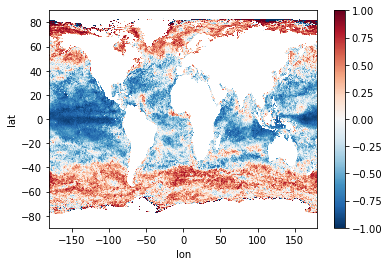

In [52]:
sat_npp_sst_corr.plot()

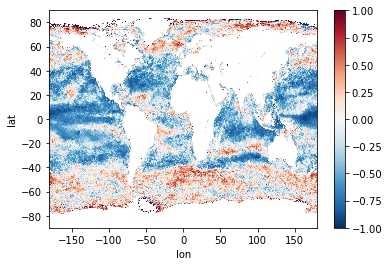

In [53]:
sat_chl_sst_corr.plot()

In [54]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

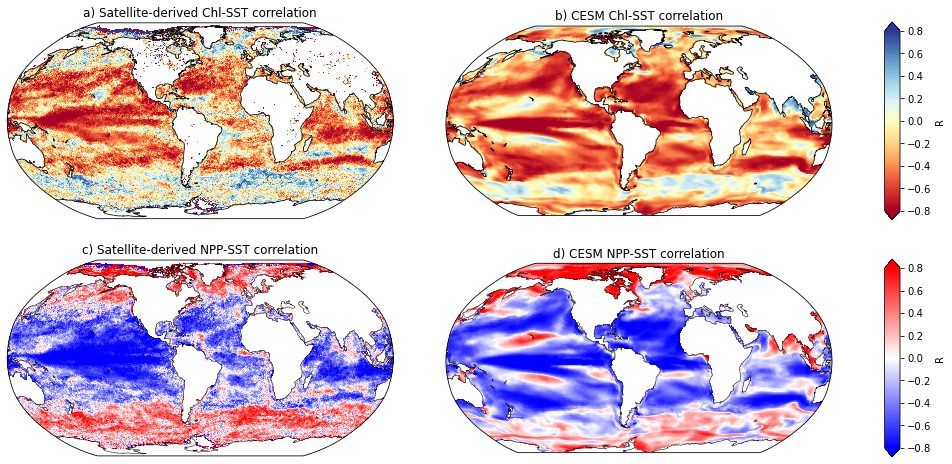

In [55]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 0.04))

prj = ccrs.Robinson(central_longitude=305.0)

ax_chl_sat = plt.subplot(gs[0, 0], projection=prj)
ax_chl_cesm = plt.subplot(gs[0, 1], projection=prj)
ax_npp_sat = plt.subplot(gs[1, 0], projection=prj)
ax_npp_cesm = plt.subplot(gs[1, 1], projection=prj)

ax_chl_sat.set_title('a) Satellite-derived Chl-SST correlation', fontsize=12)
pc_chl_sat=ax_chl_sat.pcolormesh(ds_sat_sst.lon, ds_sat_sst.lat, sat_chl_sst_corr, 
                     cmap='RdYlBu',vmin=-0.8, vmax=0.8,
                     transform=ccrs.PlateCarree())
ax_chl_sat.coastlines('110m',linewidth=0.75)

ax_chl_cesm.set_title('b) CESM Chl-SST correlation', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  SST_chl_corr)
ax_chl_cesm.coastlines('110m',linewidth=0.75)
pc_chl_cesm=ax_chl_cesm.pcolormesh(lon, lat, field, 
                 cmap='RdYlBu',vmin=-0.8, vmax=0.8,
                    transform=ccrs.PlateCarree())




ax_npp_sat.set_title('c) Satellite-derived NPP-SST correlation', fontsize=12)
pc_npp_sat=ax_npp_sat.pcolormesh(sat_npp_sst_corr.lon, sat_npp_sst_corr.lat, sat_npp_sst_corr, 
                                    cmap='bwr',vmin=-0.8, vmax=0.8,transform=ccrs.PlateCarree())
ax_npp_sat.coastlines('110m',linewidth=0.5)

ax_npp_cesm.set_title('d) CESM NPP-SST correlation', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats, SST_NPP_corr)
pc_npp_cesm=ax_npp_cesm.pcolormesh(lon, lat, field, 
                                     cmap='bwr',vmin=-0.8, vmax=0.8,
                                     transform=ccrs.PlateCarree())
ax_npp_cesm.coastlines('110m',linewidth=0.5)

cax_chl = plt.subplot(gs[0, 2])
cax_npp = plt.subplot(gs[1, 2])

cb_chl = plt.colorbar(pc_chl_cesm, cax=cax_chl,extend='both', 
                      label='R')
cb_npp = plt.colorbar(pc_npp_cesm, cax=cax_npp,extend='both', label='R')
